In [1]:
!pip install folium
!pip install seaborn
!pip install haversine
!pip install tables
!pip install pandas
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 221.2 kB/s eta 0:00:00 kB/s eta 0:00:01:01
  Using cached xyzservices-2024.4.0-py3-none-any.whl (81 kB)
  Using cached haversine-2.8.1-py2.py3-none-any.whl (7.7 kB)


In [2]:
import common
import pandas as pd
import haversine as hs
import numpy as np

In [3]:
# Read list.json to pandas dataframe, or load it from a file

df = common.df_from_list('list.json')
df.to_hdf('df.h5', 'df')

#df = pd.read_hdf('df.h5', 'df')

print("sla is starting point latitude, slo is starting point longitude, ela is ending point latitude, elo is ending point longitude")

df

sla is starting point latitude, slo is starting point longitude, ela is ending point latitude, elo is ending point longitude


,datetime,duration_minutes,sla,slo,ela,elo
0,2023-01-03 12:11:00,9.650000,49.197684,16.640210,49.189396,16.617106
1,2023-01-03 17:57:55,11.550000,49.189396,16.617106,49.201914,16.641787
2,2023-01-04 11:48:46,10.550000,49.201914,16.641787,49.191415,16.619807
3,2023-01-04 17:53:59,12.533333,49.189396,16.617106,49.201914,16.641787
4,2023-01-09 11:49:58,11.033333,49.201914,16.641787,49.191415,16.619807
...,...,...,...,...,...,...
420,2024-05-17 10:18:11,16.283333,49.195861,16.650252,49.196597,16.608866
421,2024-05-18 12:53:03,4.116667,49.195861,16.650252,49.201914,16.641787
422,2024-05-19 15:45:10,3.850000,49.203719,16.636573,49.201914,16.641787
423,2024-05-21 06:52:54,8.950000,49.195861,16.650252,49.203719,16.636573


In [4]:
pd.set_option('display.precision', 2)

# Calulate distance between start and end location

# we use haversine package to calculate the distance between two points
df['distance_km'] = df.apply(lambda x: hs.haversine((x['sla'], x['slo']), (x['ela'], x['elo']), unit=hs.Unit.KILOMETERS), axis=1)

# I measured that travel distance is approximately 1.25 times the aerial distance
df['real_distance_km'] = df.distance_km * 1.25


# Cleanup

# I never drive more than 50 km on nextbike, anything so high is an error
df = df[df.distance_km < 50]
df = df[df.distance_km > 0]

# I never spent more than 2 hours on nextbike
df = df[df.duration_minutes < 120]

df

,datetime,duration_minutes,sla,slo,ela,elo,distance_km,real_distance_km
0,2023-01-03 12:11:00,9.65,49.20,16.64,49.19,16.62,1.92,2.39
1,2023-01-03 17:57:55,11.55,49.19,16.62,49.20,16.64,2.27,2.84
2,2023-01-04 11:48:46,10.55,49.20,16.64,49.19,16.62,1.98,2.47
3,2023-01-04 17:53:59,12.53,49.19,16.62,49.20,16.64,2.27,2.84
4,2023-01-09 11:49:58,11.03,49.20,16.64,49.19,16.62,1.98,2.47
...,...,...,...,...,...,...,...,...
420,2024-05-17 10:18:11,16.28,49.20,16.65,49.20,16.61,3.01,3.76
421,2024-05-18 12:53:03,4.12,49.20,16.65,49.20,16.64,0.91,1.14
422,2024-05-19 15:45:10,3.85,49.20,16.64,49.20,16.64,0.43,0.54
423,2024-05-21 06:52:54,8.95,49.20,16.65,49.20,16.64,1.32,1.65


Text(0.5, 0, 'Trip length (km)')

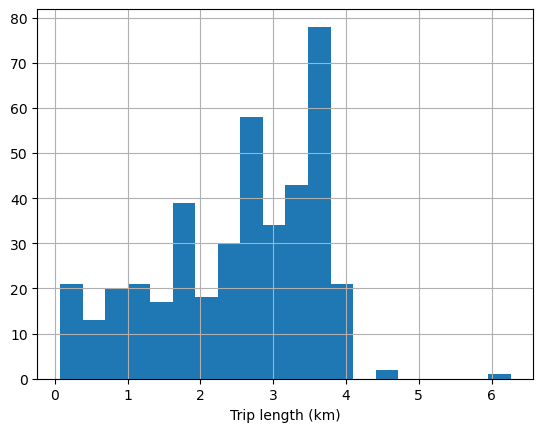

In [5]:
# how long trips I have taken

ax = df.real_distance_km.hist(bins=20)
ax.set_xlabel("Trip length (km)")

The histogram above shows that I mostly ride trips around 3-4 km. Rarely more than that, and less than 2 km is usually OK to walk.

There are peaks - those are routes that I take more often, probably commuting route.

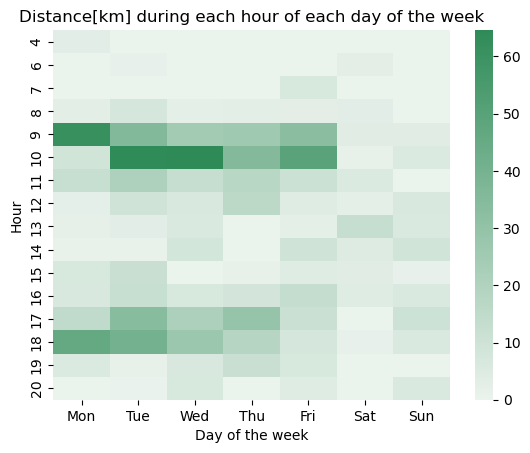

In [6]:
# heatgrid to show when I have taken trips

import seaborn as sns
import matplotlib.pyplot as plt

weekday_list = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

heat_df = df[['datetime', 'real_distance_km']].copy()
heat_df['Day of the week'] = pd.Categorical(heat_df.datetime.dt.day_of_week.map(lambda x: weekday_list[x]),
                                             categories=weekday_list, ordered=True)
heat_df['Hour'] = heat_df.datetime.dt.hour


sns.heatmap(
    heat_df.pivot_table(index='Hour', columns='Day of the week', values='real_distance_km', aggfunc='sum', observed=False),
    cmap=sns.light_palette("seagreen", as_cmap=True))
plt.title("Distance[km] during each hour of each day of the week")
plt.savefig('timegrid.png')
plt.show()


I mostly ride nextbike at 9 or 10 in the morning and then 17 or 18 in the evening during weekdays. It's intersting that I ride less later in he week. I can't think of why..

In [7]:
# Print general stats about my rides


print("Total distance travelled:  %.2f km" % df.real_distance_km.sum())
print("Total time spent: %.2f" % (df.duration_minutes.sum() / 60), "hours")
print("Total trips:", df.shape[0])

Total distance travelled:  1055.76 km
Total time spent: 78.00 hours
Total trips: 416


In [9]:
# Print monthly aggregated stats

month_agg = common.time_agg(df, 'M', "%Y-%m")
month_agg.index.rename('month', inplace=True)
month_agg['duration_hours'] = pd.to_datetime(month_agg.duration_minutes, unit='m').dt.strftime('%H:%M')
month_agg['speed_kmph'] = month_agg.real_distance_km/(month_agg.duration_minutes/60)

month_agg.drop('duration_minutes', axis=1, inplace=True)


month_agg

,real_distance_km,trips,duration_hours,speed_kmph
month,,,,
2023-01,78.54,33,05:53,13.32
2023-02,55.93,32,04:48,11.63
2023-03,69.04,44,05:17,13.04
2023-04,52.82,25,03:50,13.73
2023-05,63.83,29,04:47,13.31
2023-06,12.62,6,00:52,14.38
2023-09,50.36,17,03:39,13.79
2023-10,97.13,33,06:44,14.41
2023-11,119.47,37,08:40,13.78


In [10]:
# Print daily averages

day_agg = common.time_agg(df, 'D', "%Y-%m-%d")
day_agg.index.rename('date', inplace=True)
day_agg['speed_kmph'] = day_agg.real_distance_km / (day_agg.duration_minutes/60)

print("Average distance per day: %.2f km" % day_agg.real_distance_km.mean())
print("Average number of trips per day: %.2f" % day_agg.trips.mean())
print("Average time spent on bike per day: %.2f minutes" % day_agg.duration_minutes.mean())
day_agg


Average distance per day: 4.51 km
Average number of trips per day: 1.78
Average time spent on bike per day: 20.00 minutes


,real_distance_km,duration_minutes,trips,speed_kmph
date,,,,
2023-01-03,5.23,21.20,2,14.81
2023-01-04,5.31,23.08,2,13.80
2023-01-09,5.31,24.05,2,13.25
2023-01-10,4.01,18.05,2,13.33
2023-01-11,5.88,26.72,3,13.21
...,...,...,...,...
2024-05-17,3.76,16.28,1,13.86
2024-05-18,1.14,4.12,1,16.61
2024-05-19,0.54,3.85,1,8.35


In [11]:
import folium
import pandas as pd

tiles = 'https://tiles.stadiamaps.com/tiles/stamen_toner/{z}/{x}/{y}@2x.png?api_key=e014ecc6-b337-46f2-894e-84d0e652821d'
attr = "stamen Toner"
m = folium.Map(tiles = tiles, attr=attr) 
def create_map(points,w=1, o=0.1):    
    coordinates = []
    for p in points:
       coordinates.append(p[0])
       coordinates.append(p[-1])
    coordSet = set(coordinates)
    for c in coordSet:
        folium.Circle(c, radius=16, color='blue').add_to(m)
    folium.PolyLine(points,color = 'red',  weight=w, opacity=o).add_to(m)
    df = pd.DataFrame(coordinates).rename(columns={0:'Lat', 1:'Lon'})[['Lat', 'Lon']]
    sw = df[['Lat', 'Lon']].min().values.tolist()
    ne = df[['Lat', 'Lon']].max().values.tolist()
    m.fit_bounds([sw, ne])
    return m

In [12]:
# get (start, end) location tuples
lines = [((i.sla, i.slo), (i.ela, i.elo)) for i in df.itertuples()]

# get bezier curves so that we can se 
arclines = [common.interpolate_arc(i[0][0], i[0][1], i[1][0], i[1][1], 30) for i in lines]

In [13]:

mymap = create_map(arclines,1,.4)
mymap

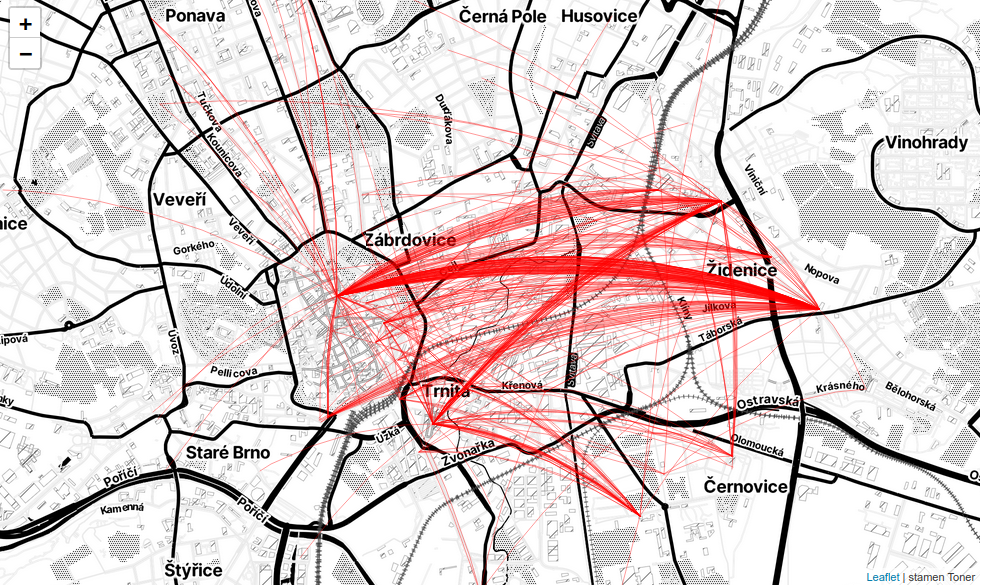

In [13]:
# The map looks more or less like this

from IPython.display import Image
Image(filename='map.png') 